##
## Temi
##


The notebook is used to play around and all that stuff

#### Set up

In [1]:
import os
import numpy as np
import importlib

In [3]:
os.getcwd()
os.chdir('/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/test_run')

### Test the multiprocessing pool to aggregate multiple files

I use this to test my functions that help to aggregate the predictions

In [3]:
import utils
importlib.reload(utils)

<module 'utils' from '/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/helpers/utils.py'>

In [5]:
h5_files_dir = '../prediction_folder/enformer_predictions/cistrome_AR/predictions_2023-01-24/cistrome/'
os.path.isdir(h5_files_dir)

True

Here I will read 20 motifs

In [10]:
h5_files = os.listdir(h5_files_dir)[0:20]
motifs = ['_'.join(h.split('_')[0:3]) for h in h5_files]
motifs[0:4], len(motifs)

(['chr9_66943762_66943771',
  'chr11_130862021_130862030',
  'chr8_2573263_2573272',
  'chr1_211474183_211474192'],
 20)

In [11]:
h5_predictions = [utils.read_file(m, h5_files_dir) for m in motifs]
h5_predictions =  {k: v for d in h5_predictions for k, v in d.items()}
h5_predictions

{'chr9_66943762_66943771': array([[0.08063664, 0.12737752, 0.11388403, ..., 0.00596294, 0.03120329,
         0.04742806],
        [0.13302283, 0.18834506, 0.0856443 , ..., 0.01001805, 0.06463382,
         0.08324532],
        [0.07578191, 0.10179935, 0.06314178, ..., 0.00517672, 0.02608535,
         0.0223082 ],
        ...,
        [0.04952738, 0.05461145, 0.06767036, ..., 0.00909393, 0.02509049,
         0.01374595],
        [0.06451581, 0.06840262, 0.0955685 , ..., 0.01183867, 0.03387516,
         0.0167965 ],
        [0.05021173, 0.05038195, 0.05846206, ..., 0.00364656, 0.01734603,
         0.01089448]], dtype=float32),
 'chr11_130862021_130862030': array([[0.12927958, 0.12927222, 0.10939392, ..., 0.00330115, 0.04640604,
         0.02006413],
        [0.1803764 , 0.17099352, 0.14611177, ..., 0.01003553, 0.08119576,
         0.02783836],
        [0.18431626, 0.18088901, 0.1655869 , ..., 0.00866537, 0.06991176,
         0.0299842 ],
        ...,
        [0.21393728, 0.22304513, 0.139

In [14]:
pred_mean = utils.agg_by_mean(h5_predictions)
pred_mean.shape

(20, 5314)

### Query VCFs and changing variants

Here I test how to query vcf files and create variants

In [5]:
import cyvcf2, kipoiseq
import os, sys
import numpy as np
import importlib
import subprocess

GPUs might become necessary down the line

In [6]:
subprocess.call('nvidia-smi') # just checking if you have GPUs available

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



9

In [7]:
os.chdir('/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/test_run')
os.getcwd()

'/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/test_run'

I am going to use the enformer predict modules

In [8]:
sys.path.append('/lus/grand/projects/covid-ct/imlab/users/shared/enformer_pipeline/parallel_enformer/batch_utils')
sys.path

['/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/helpers',
 '/home/temi/miniconda3/envs/dl-tools/lib/python310.zip',
 '/home/temi/miniconda3/envs/dl-tools/lib/python3.10',
 '/home/temi/miniconda3/envs/dl-tools/lib/python3.10/lib-dynload',
 '',
 '/home/temi/miniconda3/envs/dl-tools/lib/python3.10/site-packages',
 '/lus/grand/projects/covid-ct/imlab/users/shared/enformer_pipeline/parallel_enformer/batch_utils']

##### Here I test how manipulating reference sequences may work

Import `sequencesUtils`

In [97]:
# import utilities
# importlib.reload(utilities)

import sequencesUtils
importlib.reload(sequencesUtils)

<module 'sequencesUtils' from '/lus/grand/projects/covid-ct/imlab/users/shared/enformer_pipeline/parallel_enformer/batch_utils/sequencesUtils.py'>

In [77]:
#samples = ['LuCaP_173', 'LuCaP_145', 'LuCaP_70', 'LuCaP_00'] # LuCaP_000 does not exist
samples = ['LuCaP_173'] # LuCaP_000 does not exist

In [78]:
path_to_vcf= '../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz'
if os.path.isfile(path_to_vcf):
    myvcf = cyvcf2.cyvcf2.VCF(path_to_vcf, samples=samples)
else: print('vcf file not found')

[W::hts_idx_load3] The index file is older than the data file: ../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz.tbi


In [79]:
path_to_fasta = '../../../../../../data/hg_sequences/hg38/Homo_sapiens_assembly38.fasta'
if os.path.isfile(path_to_fasta):   
    fasta_object = sequencesUtils.FastaStringExtractor(path_to_fasta)
else: print('Fasta file not found')

You can get the samples read by the vcf parser this way

In [80]:
myvcf.samples

['LuCaP_173']

And given a region, you can extract variants this way

In [81]:
short_query_region = 'chr1:150333985-150333994'#'chr17:71028800-71028820'
for v in myvcf(short_query_region):
    print(v.CHROM, v.POS, v.genotypes, v.gt_bases)

chr1 150333991 [[0, 1, True]] ['T|C']


[W::hts_idx_load3] The index file is older than the data file: ../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz.tbi


Extract that region from the vcf file

In [82]:
short_query_region = short_query_region.replace(':', '_').replace('-', '_')
short_query_region # I need this format

'chr1_150333985_150333994'

In [83]:
ref_seq = sequencesUtils.extract_reference_sequence(region=short_query_region, fasta_func=fasta_object, resize_length=None, print_sequence=True, resize_for_enformer=True)
ref_seq, ref_seq['sequence'].shape

AATACTCAAGATGTGCACTAACTAGTAAGACAAACCATTAGAAGAGAATTAGGAGGAAGAAAACCCGCTCACTGCCTTCTGTCCTGTCATAGGGGATGAATGCTCCTAGCTGGGGCTAGCTCTTCCACTTGGGCACCAGAGCCCATCTACCTCACCTACACCGGGATATCTCTCCAAACTCCCCTTTCTTTCCCAAATCATTTTTTCCCACCTGTTGTATTATTCATAGAAGCATAGAAATATCCTGCTATGCTGGGCACAGTGGCTCACGCCTGTAATCCTAGCACTTTTGGAGGCTGAGGTGGGCAGATTGCCTGAGCTCAGCAGTTTGAGACCAGCCTGGGCAACACAGTGAAACCTCATCTCTACTAAAATATAAAAAATTAGCCAGGCATGGCGGCGTATTTCTGTAGTCCCAGCTACTCAGGAGGCTGAGGCAGGAGAATTGCTTGAACCCGGGAGGTGGAGGTTGCAGTGAGCCGAGATTGTGCCACTGCACTCCAGCCTAGGCGACAGAGTGAGACTCCGTCTCCAAAAAAAAAAAAAAAAAAAACAGTTTGAAATATCCTGCTATGTTCTGCATCTTTAAAAGCCCTCTCTTAACCCCCTTACTCTTTCTAGGCTCCATCTCATTTCTGTGTTCTCTTTCATGGGAAAATTCTCCAAGAGTTGTTTACACTCACTGTCTCTAATTCCTTCCCTCACATATTCTCTTAAATCCACATATTCTCCTCAACTACTGCATTCAGGCCTTCACTCCCATCACTCTAAAATCGCTGTTGTCAGGGTCCCTAGGGACCTCCACATAGCTAAACATAGAGTCAACTTTCAGTCCTCATTTTGCTTGACCTATCAGCAGCATCTGACGCAGTTCCCTTACTTATTTTTTAAAAAAAAATAGAGATGAGGTATTGCTATGTTGCGCAGGCTGGTCGTTGTTATCACTTAGCTTCCAGGAACTATACTGTCTTGGTCGTCCTACCTCACTGGCCATTCCTTC

({'sequence': array([[[1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 0., 1.],
          ...,
          [0., 0., 1., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.]]], dtype=float32),
  'interval_object': {'chr': 'chr1', 'start': 150137383, 'end': 150530599}},
 (1, 393216, 4))

Find variants belonging to that region

In [84]:
variants_in_samples = sequencesUtils.find_variants_in_vcf_file(cyvcf2_object=myvcf, interval_object=ref_seq['interval_object'], samples=samples)
variants_in_samples

{'chr': 'chr1',
 'positions': (150137894,
  150138272,
  150138317,
  150139439,
  150139567,
  150139816,
  150140312,
  150141312,
  150143220,
  150143308,
  150143445,
  150143798,
  150145437,
  150146446,
  150146961,
  150146987,
  150147297,
  150147304,
  150147315,
  150147317,
  150147354,
  150147359,
  150147373,
  150147380,
  150147393,
  150147403,
  150147404,
  150147405,
  150147432,
  150147443,
  150147444,
  150147447,
  150147453,
  150147458,
  150147469,
  150147470,
  150147473,
  150147539,
  150147751,
  150148889,
  150149739,
  150150179,
  150150932,
  150150936,
  150150941,
  150150942,
  150151031,
  150151044,
  150151049,
  150151061,
  150151064,
  150151068,
  150151084,
  150151572,
  150152425,
  150152609,
  150152713,
  150153057,
  150153170,
  150154884,
  150154910,
  150156083,
  150156085,
  150156089,
  150156095,
  150156122,
  150156137,
  150156164,
  150156173,
  150156176,
  150156179,
  150156184,
  150156185,
  150156187,
  1501561

`chr` is the chromosome

`positions` are the positions

and the rest are the individuals and their sequences at those positions

I need to create a mapping dictionary that turns these sequences into one-hot encoded numpy arrays

In [85]:
variants_map = sequencesUtils.create_mapping_dictionary(variants_in_samples, ref_seq['interval_object']['start'], sequence_source='personalized')
variants_map

{'positions': (511,
  889,
  934,
  2056,
  2184,
  2433,
  2929,
  3929,
  5837,
  5925,
  6062,
  6415,
  8054,
  9063,
  9578,
  9604,
  9914,
  9921,
  9932,
  9934,
  9971,
  9976,
  9990,
  9997,
  10010,
  10020,
  10021,
  10022,
  10049,
  10060,
  10061,
  10064,
  10070,
  10075,
  10086,
  10087,
  10090,
  10156,
  10368,
  11506,
  12356,
  12796,
  13549,
  13553,
  13558,
  13559,
  13648,
  13661,
  13666,
  13678,
  13681,
  13685,
  13701,
  14189,
  15042,
  15226,
  15330,
  15674,
  15787,
  17501,
  17527,
  18700,
  18702,
  18706,
  18712,
  18739,
  18754,
  18781,
  18790,
  18793,
  18796,
  18801,
  18802,
  18804,
  18807,
  18814,
  18817,
  18819,
  18848,
  19539,
  19551,
  19560,
  19572,
  19575,
  19584,
  19590,
  19592,
  19593,
  19602,
  19606,
  19611,
  19614,
  19758,
  19935,
  19937,
  19941,
  19946,
  19947,
  19959,
  19967,
  19974,
  19978,
  19982,
  19990,
  20034,
  20037,
  20049,
  20061,
  20073,
  20076,
  20082,
  20083,
  2009

In [86]:
variants_sequences = sequencesUtils.replace_variants_in_reference_sequence(ref_seq['sequence'], variants_map)
variants_sequences

{'LuCaP_173': {'haplotype1': array([[[1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 0., 1.],
          ...,
          [0., 0., 1., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.]]], dtype=float32),
  'haplotype2': array([[[1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 0., 1.],
          ...,
          [0., 0., 1., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.]]], dtype=float32)}}

Now, I have the indices of the positions (as opposed to coordinates), and the individuals have been converted to np arrays 

In [87]:
# Here I define a function to reverse_one_hot_encode a numpy array

def reverse_encode_into_sequences(input_array, delim_indices):

    import copy 
    # never change this whatsoever
    A = np.array([1,0,0,0], dtype=np.float32)
    C = np.array([0,1,0,0], dtype=np.float32)
    G = np.array([0,0,1,0], dtype=np.float32)
    T = np.array([0,0,0,1], dtype=np.float32)
    seq_dict = {'A': A, 'C': C, 'G': G, 'T': T}

    keys = list(seq_dict.keys())
    values = list(seq_dict.values())
    values = [ar.tolist() for ar in values]

    if len(input_array.shape) != 3:
        raise Exception('Input array should have 3 dimensions')

    seq_list = []
    for i, na in enumerate(range(input_array.shape[1])):
        ts = input_array[:,i,:].tolist()[0]
        # look up in the dictionary
        id = values.index(ts)
        seq_list.append(keys[id])

    seq = [seq_list[i] if i in delim_indices else seq_list[i].lower() for i in range(len(seq_list)) ] #

    return(''.join(seq))

In [88]:
reverse_encode_into_sequences(ref_seq['sequence'], variants_map['positions'])

KeyboardInterrupt: 

I go through each individual's haplotypes variants sequence, reverse encode the already encoded sequences, and see that they have been changed appropriately in the reference sequence

Variants are in upper case

In [44]:
print(f'Reference sequence: {reverse_encode_into_sequences(ref_seq["sequence"], variants_map["positions"])}')

for sample, dt in variants_sequences.items():
    for haplotype, hap_sequences in dt.items():
        print(f'{sample}-{haplotype}: {reverse_encode_into_sequences(hap_sequences, variants_map["positions"])}')

Reference sequence: aatactcaagatgtgcactaactagtaagacaaaccattagaagagaattaggaggaagaaaacccgctcactgccttctgtcctgtcataggggatgaatgctcctagctggggctagctcttccacttgggcaccagagcccatctacctcacctacaccgggatatctctccaaactcccctttctttcccaaatcattttttcccacctgttgtattattcatagaagcatagaaatatcctgctatgctgggcacagtggctcacgcctgtaatcctagcacttttggaggctgaggtgggcagattgcctgagctcagcagtttgagaccagcctgggcaacacagtgaaacctcatctctactaaaatataaaaaattagccaggcatggcggcgtatttctgtagtcccagctactcaggaggctgaggcaggagaattgcttgaacccgggaggtggaggttgcagtgagccgagattgtgccactgcactccagcctaggcGacagagtgagactccgtctccaaaaaaaaaaaaaaaaaaaacagtttgaaatatcctgctatgttctgcatctttaaaagccctctcttaacccccttactctttctaggctccatctcatttctgtgttctctttcatgggaaaattctccaagagttgtttacactcactgtctctaattccttccctcacatattctcttaaatccacatattctcctcaactactgcattcaggccttcactcccatcactctaaaatcgctgttgtcagggtccctagggacctccacatagctaaacatagagtcaactttcagtcctcattttgcttgacctatcagcagcatctgacgcagttcccttacttattttttAaaaaaaaatagagatgaggtattgctatgttgcgcaggctggtcGttgttatcacttagcttccaggaactatactgtcttggtcgtcct

### Create encoded input sequences for ENFORMER

-: Handle edge cases
1. the region does not have a variant in the vcf file
2. a sample is not the vcf file
3. the sequences from the reference genome are `NNNNNNNNNN...`

In [110]:
query_list = ['chr1:103268936-103268945', 'chr1:150333985-150333994', 'chr12:45119102-45119111', 'chr8:146200116-146200125']
query_list = ['chr1_103268936_103268945', 'chr1_150333985_150333994', 'chr12_45119102_45119111', 'chr8_146200116_146200125', 'chr1_20_50']

The regions need to be in a certain format

In [89]:
# batch_regions = [{'query': q, 'logtype': 'y'} for q in query_list]
# batch_regions

batch_regions = [{'query': short_query_region, 'logtype':'n'}]
batch_regions

[{'query': 'chr1_150333985_150333994', 'logtype': 'n'}]

In [90]:
batch_regions[0]['query']

'chr1_150333985_150333994'

In [98]:
samples_enformer_inputs = sequencesUtils.create_input_for_enformer(query_region=batch_regions[0]['query'], samples=samples, path_to_vcf=path_to_vcf, fasta_func=fasta_object, hap_type = 'both', resize_for_enformer=True, resize_length=None, write_log=None, sequence_source='personalized', reverse_complement=True)

samples_enformer_inputs

[W::hts_idx_load3] The index file is older than the data file: ../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: ../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz.tbi


{'sequence': {'LuCaP_173': {'haplotype1': array([[[1., 0., 0., 0.],
           [1., 0., 0., 0.],
           [0., 0., 0., 1.],
           ...,
           [0., 0., 1., 0.],
           [1., 0., 0., 0.],
           [1., 0., 0., 0.]]], dtype=float32),
   'haplotype2': array([[[1., 0., 0., 0.],
           [1., 0., 0., 0.],
           [0., 0., 0., 1.],
           ...,
           [0., 0., 1., 0.],
           [1., 0., 0., 0.],
           [1., 0., 0., 0.]]], dtype=float32),
   'haplotype1_rc': array([[[0., 0., 0., 1.],
           [0., 0., 0., 1.],
           [0., 1., 0., 0.],
           ...,
           [1., 0., 0., 0.],
           [0., 0., 0., 1.],
           [0., 0., 0., 1.]]], dtype=float32),
   'haplotype2_rc': array([[[0., 0., 0., 1.],
           [0., 0., 0., 1.],
           [0., 1., 0., 0.],
           ...,
           [1., 0., 0., 0.],
           [0., 0., 0., 1.],
           [0., 0., 0., 1.]]], dtype=float32)}},
 'metadata': {'sequence_source': 'var', 'region': 'chr1_150333985_150333994'}}

#### Load Enformer

In [35]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

2023-03-14 17:19:52.560179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /soft/perftools/darshan/darshan-3.3.0/lib:/opt/cray/pe/papi/6.0.0.1/lib64:/opt/cray/job/2.2.4-7.0.2.1_3.25__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2020.0.166/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2020.0.166/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2020.0.166/linux/mpi/intel64/lib:/opt/intel/compilers_and_libraries_2020.0.166/linux/mpi/mic/lib:/opt/intel/compilers_and_libraries_2020.0.166/linux/ipp/lib/intel64:/opt/intel/compilers_and_libraries_2020.0.166/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2020.0.166/linux/mkl/lib/intel64:/opt/intel/compilers_and_libraries_2020.0.166/linux/tbb/lib/intel64/gcc4.4:/opt/intel/debugger_2020/libipt/intel64/lib:/opt/intel/comp

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [36]:
enformer_model = tf.saved_model.load('../../../../../../data/enformer/raw').model

2023-03-14 17:20:12.902426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [99]:
samples_enformer_inputs['sequence'][samples[0]]['haplotype1'].shape

(1, 393216, 4)

In [100]:
hap1_predictions = enformer_model.predict_on_batch(samples_enformer_inputs['sequence'][samples[0]]['haplotype1'])['human'][0, :, :]
hap1_rc_predictions = enformer_model.predict_on_batch(samples_enformer_inputs['sequence'][samples[0]]['haplotype1_rc'])['human'][0, :, :]
hap1_rrc_predictions = enformer_model.predict_on_batch(rrc_seq)['human'][0,:,:]

In [101]:
assert hap1_predictions.shape == hap1_rc_predictions.shape == hap1_rrc_predictions.shape == (896, 5313), 'Shapes are not equal'

#### Plotting tracks

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import kipoiseq

def plot_tracks(tracks, chr, interval_start, interval_end, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(interval_start, interval_end, num=len(y)), y)
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel(chr+":"+str(interval_start)+"-"+str(interval_end))
    plt.tight_layout()

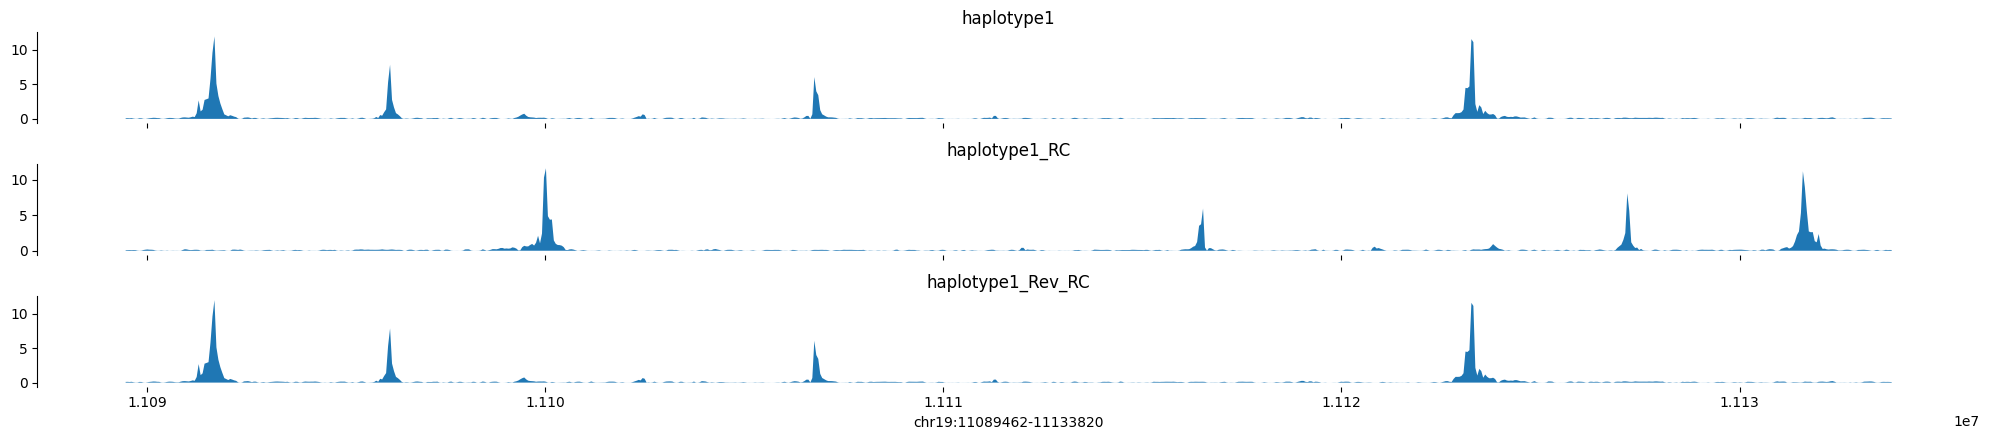

In [103]:
    
tracks = {"haplotype1":hap1_predictions[:,0],
          "haplotype1_RC":hap1_rc_predictions[:,0],
          "haplotype1_Rev_RC":hap1_rrc_predictions[:,0]}

LDLR_interval = kipoiseq.Interval("chr19", # creates a kipoiseq interval to select the right sequences
                        11089462,
                        11133820)
LDLR_interval_resized = LDLR_interval.resize(114688)
plot_tracks(tracks, "chr19", LDLR_interval.start,LDLR_interval.end)

### 
Check that the reverse complement of hap1 is the same as hap1

In [69]:
orig_seq = samples_enformer_inputs['sequence'][samples[0]]['haplotype1']
rrc_seq = sequencesUtils.reverse_complement_one_hot_encoded_sequences(samples_enformer_inputs['sequence'][samples[0]]['haplotype1_rc'])
rrc_seq.shape, orig_seq.shape

((1, 393216, 4), (1, 393216, 4))

In [70]:
np.array_equal(orig_seq, rrc_seq)

True

In [28]:
samples_enformer_inputs = [sequencesUtils.create_input_for_enformer(query_region=loci, samples=samples, path_to_vcf=path_to_vcf, 
    fasta_func=fasta_object, hap_type = 'both', 
    resize_for_enformer=False, resize_length=None, 
    write_log=None, sequence_source='personalized', reverse_complement=True) for loci in batch_regions['query']]

samples_enformer_inputs

TypeError: list indices must be integers or slices, not str

In [119]:
len(samples_enformer_inputs)

5

In [124]:
samples_enformer_inputs[2]

{'sequence': {'haplotype1': array([[[0., 0., 0., 1.],
          [0., 1., 0., 0.],
          [0., 0., 0., 1.],
          [0., 1., 0., 0.],
          [0., 0., 0., 1.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.]]], dtype=float32),
  'haplotype2': array([[[0., 0., 0., 1.],
          [0., 1., 0., 0.],
          [0., 0., 0., 1.],
          [0., 1., 0., 0.],
          [0., 0., 0., 1.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 0., 1.],
          [0., 0., 0., 1.]]], dtype=float32)},
 'metadata': {'sequence_source': 'ref',
  'region': 'chr12_45119102_45119111',
  'logtype': 'y',
  'samples': ['LuCaP_173', 'LuCaP_145', 'LuCaP_70', 'LuCap_00']}}

In [90]:
ref_seq = sequencesUtils.extract_reference_sequence(region=query_list[1], fasta_func=fasta_object, resize_length=50, resize_for_enformer=True)
ref_seq, ref_seq['sequence'].shape

extracting reference sequence
finished extracting reference sequence of length 393216


({'sequence': array([[[1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 0., 1.],
          ...,
          [0., 0., 1., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.]]], dtype=float32),
  'interval_object': Interval(chrom='chr1', start=150137382, end=150530598, name='', strand='.', ...)},
 (1, 393216, 4))

In [ ]:
variants_in_samples = find_variants_in_vcf_file(cyvcf2_object=myvcf, interval_object=ref_seq['interval_object'], samples=samples[0:3])

In [ ]:
#  look at
variants_in_samples['positions'] ; variants_in_samples['LuCaP_173']

In [20]:
samples_mapping_dictionary = create_mapping_dictionary(variants_in_samples, ref_seq['interval_object'].start, haplotype='both')

In [22]:
samples_mapping_dictionary.keys()

dict_keys(['positions', 'LuCaP_173', 'LuCaP_145', 'LuCaP_70'])

In [ ]:
replace_variants_in_reference_sequence(ref_seq['sequence'], samples_mapping_dictionary)

In [14]:
def create_input_for_enformer(region_details, samples, path_to_vcf, fasta_func, hap_type = 'both', vcf_func=None, resize_for_enformer=True, resize_length=None, write_log=None, sequence_source=None):
    '''
    Given a region in the genome, a reference genome (fasta) and a VCF file, create an individual's sequence for that region

    Parameters:
        query_sequences: str
            The query, perhaps, reference sequence
        mapping_dict: a numpy array or list
            List of the regions that should be modified

    Returns:
        A new sequence with all the changes applied.
    '''

    import numpy as np
    import cyvcf2

    #print(region_details)
    region = region_details['query']
    logtype = region_details['logtype']

    if sequence_source == 'random':
        return({'sequence': {'haplotype0': one_hot_encode(generate_random_sequence_inputs())}, 'metadata': {'sequence_source':'random', 'region':region, 'logtype': logtype}})
    else:
        reference_sequence = extract_reference_sequence(region, fasta_func, resize_for_enformer)
        if np.all(reference_sequence['sequence'] == 0.25): # check if all the sequence are "NNNNNNNNNNN..."
            if write_log['error']:
                err_msg = f'[INPUT ERROR] {region} is invalid; all nucleotides are N.'
                MEMORY_ERROR_FILE = f"{log_dir}/error_details.log"
                setup_logger('error_log', MEMORY_ERROR_FILE)
                logger(err_msg, 'error', 'run_error')
            return(None)

        else:
            if sequence_source == 'reference':
                return({'sequence': {'haplotype0': reference_sequence['sequence']}, 'metadata': {'sequence_source':'ref', 'region':region, 'logtype': logtype}})
            elif sequence_source == 'personalized':
                # which vcf file
                vcf_chr = cyvcf2.cyvcf2.VCF(path_to_vcf, samples=samples)
                samples_variants = find_variants_in_vcf_file(cyvcf2_object=vcf_chr, interval_object=reference_sequence['interval_object'], samples=samples)
                if samples_variants: # go on and change the variants by position
                    samples_mapping_dictionary = create_mapping_dictionary(samples_variants, reference_sequence['interval_object'].start, haplotype='both')
                    samples_variants_encoded = replace_variants_in_reference_sequence(reference_sequence['sequence'], samples_mapping_dictionary)
                    return({'sequence': samples_variants_encoded, 'metadata': {'sequence_source':'var', 'region':region, 'logtype': logtype}})
                else: # return the reference and no need for having the same reference genome for all samples since one is enough 
                    return({'sequence':{'haplotype1': reference_sequence['sequence'], 'haplotype2': reference_sequence['sequence']}, 'metadata': {'sequence_source':'ref', 'region':region, 'logtype': logtype, 'samples': samples}})

[{'query': 'chr1_103268936_103268945', 'logtype': 'y'},
 {'query': 'chr1_150333985_150333994', 'logtype': 'y'},
 {'query': 'chr12_45119102_45119111', 'logtype': 'y'},
 {'query': 'chr8_146200116_146200125', 'logtype': 'y'}]

In [16]:
samples

['LuCaP_173', 'LuCaP_145', 'LuCaP_70']

In [131]:
samples_enformer_inputs = create_input_for_enformer(region_details=batch_regions[1], samples=samples, path_to_vcf=path_to_vcf, fasta_func=fasta_object, hap_type = 'both', resize_for_enformer=True, resize_length=None, write_log=None, sequence_source='reference')

samples_enformer_inputs

{'sequence': {'haplotype0': array([[[1., 0., 0., 0.],
          [1., 0., 0., 0.],
          [0., 0., 0., 1.],
          ...,
          [0., 0., 1., 0.],
          [1., 0., 0., 0.],
          [1., 0., 0., 0.]]], dtype=float32)},
 'metadata': {'sequence_source': 'ref',
  'region': 'chr1_150333985_150333994',
  'logtype': 'y'}}

In [19]:
import tensorflow as tf

In [20]:
output_dir = './test_output'
if not os.path.exists(output_dir): os.makedirs(output_dir)

global write_log
write_log = {'memory':False, 'error':False, 'time':False, 'cache':False}

global model
model = tf.saved_model.load('../../../../../../data/enformer/raw').model
fasta_object = utilities.FastaStringExtractor('../../../../../../data/hg_sequences/hg38/Homo_sapiens_assembly38.fasta')

2023-02-03 05:08:52.860049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 05:08:54.467357: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38417 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-02-03 05:08:54.469323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38417 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:46:00.0, compute capability: 8.0
2023-02-03 05:08:54.470568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

In [21]:
batch_regions, samples

([{'query': 'chr1_103268936_103268945', 'logtype': 'y'},
  {'query': 'chr1_150333985_150333994', 'logtype': 'y'},
  {'query': 'chr12_45119102_45119111', 'logtype': 'y'},
  {'query': 'chr8_146200116_146200125', 'logtype': 'y'}],
 ['LuCaP_173', 'LuCaP_145', 'LuCaP_70'])

In [29]:
enformer_predict_on_batch(batch_regions=batch_regions, samples=samples, path_to_vcf=path_to_vcf, batch_num=1, output_dir=output_dir, predictions_log_file='./test_output/three_people.csv')

[W::hts_idx_load3] The index file is older than the data file: ../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: ../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz.tbi


Writing log file
logfile found


[W::hts_idx_load3] The index file is older than the data file: ../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: ../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz.tbi


Writing log file
logfile found


[W::hts_idx_load3] The index file is older than the data file: ../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: ../../genotypes/prj6_genotypes/merged_phased_SNPs.vcf.gz.tbi


Writing log file
logfile found


In [21]:
import os

['HG00101_log.csv',
 'HG00103_log.csv',
 'HG00252_log.csv',
 'HG00139_log.csv',
 'HG00249_log.csv',
 'HG00235_log.csv',
 'HG00244_log.csv',
 'HG00231_log.csv',
 'HG00280_log.csv',
 'HG00150_log.csv',
 'HG00116_log.csv',
 'HG00105_log.csv',
 'HG00109_log.csv',
 'HG00117_log.csv',
 'HG00102_log.csv',
 'HG00269_log.csv',
 'HG00263_log.csv',
 'HG00276_log.csv',
 'HG00239_log.csv',
 'HG00152_log.csv',
 'HG00261_log.csv',
 'HG00327_log.csv',
 'HG00260_log.csv',
 'HG00328_log.csv',
 'HG00233_log.csv',
 'HG00138_log.csv',
 'HG00137_log.csv',
 'HG00143_log.csv',
 'HG00180_log.csv',
 'HG00251_log.csv',
 'HG00310_log.csv',
 'HG00234_log.csv',
 'HG00173_log.csv',
 'HG00185_log.csv',
 'HG00258_log.csv',
 'HG00127_log.csv',
 'HG00325_log.csv',
 'HG00131_log.csv',
 'HG00118_log.csv',
 'HG00271_log.csv',
 'HG00134_log.csv',
 'HG00285_log.csv',
 'HG00250_log.csv',
 'HG00155_log.csv',
 'HG00111_log.csv',
 'HG00108_log.csv',
 'HG00176_log.csv',
 'HG00265_log.csv',
 'HG00112_log.csv',
 'HG00326_log.csv',


In [22]:
import itertools

In [28]:
# check
def check_queries(sample, queries, output_dir, logfile, sequence_source):
    """
    Check whether a given region, for an individual has been predicted and logged.

    Parameters:
        sample: str 
            The name/id of an individual
        queries: A batch
            A region in the genome in the form `chr_start_end`.
        output_dir: str (path)
            The folder where the predictions should have been logged. 
        logfile: pd.DataFrame 
            A dataframe of a log file or `None` if the log file does not exist. 
    
    Returns: dict
        'query': the query region if it has not been logged or predictions don't exist
        'logtype': whether it should be logged if it has not been logged

    If predictions exist and the query has been logged, this function returns None.
    """
    import pandas as pd
    import os
    import numpy as np

    if isinstance(logfile, type(None)):
        output = [{'query':query, 'logtype':'y'} for query in queries]
        return(output)

    elif isinstance(logfile, pd.DataFrame):# should have read it>

        id_logfile = logfile.loc[logfile['sample'] == sample, : ]
        # check if the file is saved
        if sequence_source == 'personalized': # prediction must be present in two folders
            queries_saved_h1 = [str(f'{output_dir}/{sample}/haplotype1/{query}_predictions.h5') for query in queries]
            queries_saved_h2 = [str(f'{output_dir}/{sample}/haplotype2/{query}_predictions.h5') for query in queries]
            queries_saved = np.array([os.path.isfile(q) for q in queries_saved_h1]) * np.array([os.path.isfile(q) for q in queries_saved_h2])
        elif sequence_source == 'reference':
            queries_saved = [str(f'{output_dir}/{sample}/haplotype0/{query}_predictions.h5') for query in queries]
            queries_saved = np.array([os.path.isfile(q) for q in queries_saved])
        # check if the file is in the logfile
        query_logged = np.array([(query in id_logfile.motif.values) for query in queries])
        # 
        if not query_logged.shape[0] == queries_saved.shape[0]:
            raise Exception("Lengths of queries logged and saved conditions are not the same")
        queries_condition = queries_saved * query_logged
        queries_condition = queries_condition.tolist()
        # 
        output = [{'query':queries[i], 'logtype':'n'} if qc is True else {'query':queries[i], 'logtype':'y'} for i, qc in enumerate(queries_condition)]

        return(output)


In [29]:
query_list = ['chr1_103268936_103268945', 'chr1_150333985_150333994', 'chr12_45119102_45119111', 'chr8_146200116_146200125']

In [30]:
import pandas as pd

pt = pd.read_csv('./test_output/three_people.csv')
pt

,motif,sample,status,sequence_source
0,chr1_103268936_103268945,LuCaP_173,completed,ref
1,chr1_103268936_103268945,LuCaP_145,completed,ref
2,chr1_103268936_103268945,LuCaP_70,completed,ref
3,chr1_150333985_150333994,LuCaP_173,completed,ref
4,chr1_150333985_150333994,LuCaP_145,completed,ref
5,chr1_150333985_150333994,LuCaP_70,completed,ref
6,chr12_45119102_45119111,LuCaP_173,completed,ref
7,chr12_45119102_45119111,LuCaP_145,completed,ref
8,chr12_45119102_45119111,LuCaP_70,completed,ref
9,chr1_103268936_103268945,LuCaP_173,completed,var


In [31]:
check_these = list(itertools.product(samples, [query_list]))
check_these

[('LuCaP_173',
  ['chr1_103268936_103268945',
   'chr1_150333985_150333994',
   'chr12_45119102_45119111',
   'chr8_146200116_146200125']),
 ('LuCaP_145',
  ['chr1_103268936_103268945',
   'chr1_150333985_150333994',
   'chr12_45119102_45119111',
   'chr8_146200116_146200125']),
 ('LuCaP_70',
  ['chr1_103268936_103268945',
   'chr1_150333985_150333994',
   'chr12_45119102_45119111',
   'chr8_146200116_146200125'])]

In [32]:
checked = [check_queries(sample=cq[0], queries=cq[1], output_dir=output_dir, logfile=pt, sequence_source='personalized') for cq in check_these]
checked

[[{'query': 'chr1_103268936_103268945', 'logtype': 'n'},
  {'query': 'chr1_150333985_150333994', 'logtype': 'n'},
  {'query': 'chr12_45119102_45119111', 'logtype': 'n'},
  {'query': 'chr8_146200116_146200125', 'logtype': 'y'}],
 [{'query': 'chr1_103268936_103268945', 'logtype': 'n'},
  {'query': 'chr1_150333985_150333994', 'logtype': 'n'},
  {'query': 'chr12_45119102_45119111', 'logtype': 'n'},
  {'query': 'chr8_146200116_146200125', 'logtype': 'y'}],
 [{'query': 'chr1_103268936_103268945', 'logtype': 'n'},
  {'query': 'chr1_150333985_150333994', 'logtype': 'n'},
  {'query': 'chr12_45119102_45119111', 'logtype': 'n'},
  {'query': 'chr8_146200116_146200125', 'logtype': 'y'}]]

In [45]:
ff = [f for f in checked for f in f]
ff

[{'query': 'chr1_103268936_103268945', 'logtype': 'n'},
 {'query': 'chr1_150333985_150333994', 'logtype': 'n'},
 {'query': 'chr12_45119102_45119111', 'logtype': 'n'},
 {'query': 'chr8_146200116_146200125', 'logtype': 'y'},
 {'query': 'chr1_103268936_103268945', 'logtype': 'n'},
 {'query': 'chr1_150333985_150333994', 'logtype': 'n'},
 {'query': 'chr12_45119102_45119111', 'logtype': 'n'},
 {'query': 'chr8_146200116_146200125', 'logtype': 'y'},
 {'query': 'chr1_103268936_103268945', 'logtype': 'n'},
 {'query': 'chr1_150333985_150333994', 'logtype': 'n'},
 {'query': 'chr12_45119102_45119111', 'logtype': 'n'},
 {'query': 'chr8_146200116_146200125', 'logtype': 'y'}]

In [47]:
list({v['query']: v for v in ff}.values())

[{'query': 'chr1_103268936_103268945', 'logtype': 'n'},
 {'query': 'chr1_150333985_150333994', 'logtype': 'n'},
 {'query': 'chr12_45119102_45119111', 'logtype': 'n'},
 {'query': 'chr8_146200116_146200125', 'logtype': 'y'}]

In [43]:
{k: v for m in ff for k, v in m.items()} # {k: v for d in ini_dict for k, v in d.items()}

{'query': 'chr8_146200116_146200125', 'logtype': 'y'}

In [50]:
ind_var = utilities.find_variants_in_vcf_file(myvcf, ref_seq['interval_object'])
ind_var[0:5], len(ind_var)

([['chr1', 103072672, [0, 0], ['T', 'T']],
  ['chr1', 103073435, [0, 0], ['A', 'A']],
  ['chr1', 103073451, [0, 0], ['A', 'A']],
  ['chr1', 103074415, [0, 0], ['C', 'C']],
  ['chr1', 103074421, [0, 0], ['G', 'G']]],
 1602)

In [51]:
map_dict = utilities.create_mapping_dictionary(ind_var, ref_seq['interval_object'].start, haplotype='both')

# looking inside
len(map_dict) , map_dict.keys()

(2, dict_keys(['haplotype1', 'haplotype2']))

In [56]:
var_seq = utilities.replace_variants_in_reference_sequence(ref_seq['sequence'], map_dict)
len(var_seq)

(1, 393216, 4)
(1, 393216, 4)


2

In [32]:
ref_seq['sequence'].shape

(1, 393216, 4)

In [53]:
var_seq['haplotype1'][:, 4371, :] , var_seq['haplotype2'][:, 4371, :] #>> ['chr1', 103076704, [0, 1], ['A', 'G']]

(array([[1., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 1., 0.]], dtype=float32))

In [54]:
bool_hap = var_seq['haplotype1'] == var_seq['haplotype2']
bool_hap # some of these rows will be false because there are variants
#np.all(bool_hap == True, axis=0)

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        ...,
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]]])

#### Verifying

I can look at the true indices where there are variants, and compare that to the indices that are different between haplotypes 1 and 2 and see that they are the same. If they are the same, then my approach is working correctly.

In [15]:
def get_different_indices(ind_var, st):
    out = [(ind_var[i][1] - st) for i, _ in enumerate(ind_var) if ind_var[i][2][0] != ind_var[i][2][1]]
    return(out)

In [16]:
true_changes = get_different_indices(ind_var, ref_seq['interval_object'].start)
true_changes.sort(), len(true_changes)

(None, 183)

In [17]:
#made_changes = list(set(np.where(bool_hap == False)[1].tolist())) # ~a.any(axis=1)
made_changes = list(set(np.where(~bool_hap.any(axis=0))[0].tolist())) 
made_changes.sort(), len(made_changes)

(None, 183)

In [18]:
made_changes == true_changes

True

### Now I can put together all the code

Timing this function on 4 individuals

In [27]:
import time

tic = time.perf_counter()
out = [utilities.create_input_for_enformer(region_details=b, fasta_func=fasta_object, hap_type = 'both', vcf_func=myvcf, resize_for_enformer=True, resize_length=None, write_log=utilities.write_log, sequence_source='personalized') for b in batch_region]
toc = time.perf_counter()

(toc - tic) / 4

{'query': 'chr1_103268936_103268945', 'logtype': 'n'}
{'query': 'chr1_150333985_150333994', 'logtype': 'n'}
{'query': 'chr12_45119102_45119111', 'logtype': 'n'}
{'query': 'chr8_146200116_146200125', 'logtype': 'n'}


0.018893439235398546

### Coupling this with Enformer predict on batch

I think that having a batch of inputs (N, 393216, 4) on which to carry out inference is not necessary. Any `N` above ~ 20 results in GPU memory problems. It is better to use a for loop for all the batches. 

In [14]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [15]:
enformer_model = tf.saved_model.load('../../../../../../data/enformer/raw').model

# '../../../../../../data/hg_sequences/hg38/Homo_sapiens_assembly38.fasta'

2023-02-02 22:26:19.498934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 22:26:21.118515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38419 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-02-02 22:26:21.120519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38419 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:46:00.0, compute capability: 8.0
2023-02-02 22:26:21.121774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

In [46]:
enformer_model.predict_on_batch(ref_seq['sequence'][np.newaxis])

2023-02-01 05:40:42.846267: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-01 05:40:43.238039: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


{'human': <tf.Tensor: shape=(1, 896, 5313), dtype=float32, numpy=
 array([[[0.0448859 , 0.0338286 , 0.02249384, ..., 0.00300077,
          0.00844322, 0.0054747 ],
         [0.04086443, 0.03038296, 0.02248631, ..., 0.00447055,
          0.01325294, 0.00937136],
         [0.04369152, 0.03036681, 0.02454022, ..., 0.00513172,
          0.00897354, 0.00762524],
         ...,
         [0.02706456, 0.02111664, 0.02066585, ..., 0.00262824,
          0.00595117, 0.00492326],
         [0.03640065, 0.02561291, 0.03140229, ..., 0.00306219,
          0.00718402, 0.00764818],
         [0.03207001, 0.02182599, 0.02929399, ..., 0.00237293,
          0.00591444, 0.00633624]]], dtype=float32)>,
 'mouse': <tf.Tensor: shape=(1, 896, 1643), dtype=float32, numpy=
 array([[[0.04485861, 0.05987871, 0.0471715 , ..., 0.32980704,
          0.5065377 , 0.66570425],
         [0.04059008, 0.05534767, 0.04336205, ..., 0.2931977 ,
          0.45665944, 0.59970886],
         [0.04427745, 0.06650081, 0.06256185, ..., 

In [103]:
def enformer_predict_on_sequence(model, prepared_region):
    try:
        prediction_output = {}
        for haplotype, sequence_encoding in prepared_region['sequence'].items():
            prediction = model.predict_on_batch(sequence_encoding)['human'].numpy()[: ,range(448 - 8, (448 + 8 + 1)), : ]
            print(f'{haplotype}: {prediction.squeeze().shape}')
            prediction_output[haplotype] = prediction.squeeze()
        # delete `sequence` from the dictionary and return it
        del prepared_region['sequence']
        return( prediction_output, prepared_region )
    except ValueError:
        print(f"[ERROR] {prepared_region['region']}")
        return None
    

In [104]:
def save_batch_h5_prediction(batch_predictions, metadata, output_dir, sample):

    import h5py
    import os

    #output = []

    for key, values in batch_predictions.items():
        houtput = os.path.join(output_dir, sample, key)
        if not os.path.exists(houtput): os.makedirs(houtput)
        for i in range(0, values.shape[0]):
            region = metadata['region']
            h5save = str(f'{houtput}/{region}_predictions.h5')
            with h5py.File(h5save, 'w') as hf:
                hf.create_dataset(region, data=values[i, :])
    
    if metadata['logtype'] == 'y':
        output = [metadata['region'], sample, 'completed', metadata['sequence_source']]
    else:
        output = None

    return(output)

In [105]:
output_dir = './test_output'
if not os.path.exists(output_dir): os.makedirs(output_dir)

Testing

In [115]:
myregions = [utilities.create_input_for_enformer(region_details=b, fasta_func=fasta_object, hap_type = 'both', vcf_func=myvcf, resize_for_enformer=True, resize_length=None, write_log=utilities.write_log, sequence_source='personalized') for b in batch_region]

myregions

[{'sequence': {'haplotype1': array([[[1., 0., 0., 0.],
           [0., 0., 0., 1.],
           [1., 0., 0., 0.],
           ...,
           [1., 0., 0., 0.],
           [0., 0., 1., 0.],
           [0., 0., 0., 1.]]], dtype=float32),
   'haplotype2': array([[[1., 0., 0., 0.],
           [0., 0., 0., 1.],
           [1., 0., 0., 0.],
           ...,
           [1., 0., 0., 0.],
           [0., 0., 1., 0.],
           [0., 0., 0., 1.]]], dtype=float32)},
  'sequence_source': 'var',
  'region': 'chr1_103268936_103268945',
  'logtype': 'y'},
 {'sequence': {'haplotype1': array([[[1., 0., 0., 0.],
           [1., 0., 0., 0.],
           [0., 0., 0., 1.],
           ...,
           [0., 0., 1., 0.],
           [1., 0., 0., 0.],
           [1., 0., 0., 0.]]], dtype=float32),
   'haplotype2': array([[[1., 0., 0., 0.],
           [1., 0., 0., 0.],
           [0., 0., 0., 1.],
           ...,
           [0., 0., 1., 0.],
           [1., 0., 0., 0.],
           [1., 0., 0., 0.]]], dtype=float32)},

In [116]:
save_results = []
for myregion in myregions[0:3]:
    p, m = enformer_predict_on_sequence(enformer_model, myregion)
    save_results.append(save_batch_h5_prediction(p, m, output_dir, 'LuCaP_000'))


haplotype1: (17, 5313)
haplotype2: (17, 5313)
haplotype1: (17, 5313)
haplotype2: (17, 5313)
haplotype1: (17, 5313)
haplotype2: (17, 5313)


In [26]:
import pandas as pd

In [27]:
logfile = pd.DataFrame(save_results, columns=['motif', 'individual', 'status', 'sequence_source'])
logfile

NameError: name 'save_results' is not defined

In [123]:
def check_queries(sample, queries, output_dir, prediction_logfiles_folder, sequence_source):
    """
    Check whether a given region, for an individual has been predicted and logged.

    Parameters:
        sample: str 
            The name/id of an individual/sample
        queries: an iterable
            A batch of regions each in the genome in the form `chr_start_end`.
        output_dir: str (path)
            The folder where the predictions should have been logged. 
        prediction_logfiles_folder: a directory
            A directory within which the {sample}_log.csv file should have been logged. 
            If the file is not found, the regions are returned and will be logged after prediction.
        sequence_source: str ('personalized' or 'reference')
            where is the sequence sourced from? 
            This argument is needed to know what folders to look into within the output directory.
    
    Returns: dict
        'query': the query region if it has not been logged or predictions don't exist
        'logtype': whether it should be logged if it has not been logged i.e. 'y' or 'n'

    If predictions exist and the query has been logged, this function returns None.
    """
    import pandas as pd
    import os
    import numpy as np

    if isinstance(prediction_logfiles_folder, type(None)):
        output = [{'query':query, 'logtype':'y'} for query in queries]
        return(output)

    else:
        id_logfile = os.path.join(prediction_logfiles_folder, f'{sample}_log.csv')
        if os.path.isfile(id_logfile):
            try:
                id_logfile = pd.read_csv(id_logfile) 
                id_logfile = id_logfile.loc[id_logfile['sample'] == sample, : ]
                # check if the file is saved
                if sequence_source == 'personalized': # prediction must be present in two folders
                    queries_saved_h1 = [str(f'{output_dir}/{sample}/haplotype1/{query}_predictions.h5') for query in queries]
                    queries_saved_h2 = [str(f'{output_dir}/{sample}/haplotype2/{query}_predictions.h5') for query in queries]
                    queries_saved = np.array([os.path.isfile(q) for q in queries_saved_h1]) * np.array([os.path.isfile(q) for q in queries_saved_h2])
                elif sequence_source == 'reference':
                    queries_saved = [str(f'{output_dir}/{sample}/haplotype0/{query}_predictions.h5') for query in queries]
                    queries_saved = np.array([os.path.isfile(q) for q in queries_saved])
                # check if the file is in the logfile
                queries_logged = np.array([(query in id_logfile.motif.values) for query in queries])
                # s
                if not queries_logged.shape[0] == queries_saved.shape[0]:
                    raise Exception("Lengths of queries logged and saved conditions are not the same")
                queries_condition = queries_saved * queries_logged # true should not be predicted or logged; False should be
                queries_condition = queries_condition.tolist()
                # 
                output = [{'query':queries[i], 'logtype':'y'} for i, qc in enumerate(queries_condition) if qc is False] # assuming all predictions have not been logged hence logtype is y

                # change those regions where queries_logged == True to 'n'
                refined_output = [q_details.update({'logtype': 'n'}) for i, q_details in enumerate(output) if queries_logged[i] == True]

            except pd.errors.EmptyDataError:
                id_logfile = None
                output = [{'query':query, 'logtype':'y'} for query in queries]
        else:
            output = [{'query':query, 'logtype':'y'} for query in queries]
              
        return(output)

In [130]:
queries = [list(bb.values())[0] for bb in batch_region]
queries

['chr1_103268936_103268945',
 'chr1_150333985_150333994',
 'chr12_45119102_45119111',
 'chr8_146200116_146200125']

In [131]:
check_queries('LuCaP_000', queries, output_dir, logfile)

[{'query': 'chr1_103268936_103268945', 'logtype': 'n'},
 {'query': 'chr1_150333985_150333994', 'logtype': 'n'},
 {'query': 'chr12_45119102_45119111', 'logtype': 'n'},
 {'query': 'chr8_146200116_146200125', 'logtype': 'y'}]

In [127]:
batch_region

[{'query': 'chr1_103268936_103268945', 'logtype': 'y'},
 {'query': 'chr1_150333985_150333994', 'logtype': 'y'},
 {'query': 'chr12_45119102_45119111', 'logtype': 'y'},
 {'query': 'chr8_146200116_146200125', 'logtype': 'y'}]

In [47]:
save_batch_h5_prediction(pred, metadata, output_dir, 'LuCaP_000')

['chr12_45119102_45119111', 'LuCaP_000', 'completed', 'ref']

One function to do it all

In [49]:
pred['haplotype0'].shape

(1, 17, 5313)

In [26]:
sequence_source = 'personalized'

In [29]:
def collect_inputs_into_dict(batch_region):

    output_sequences = [utilities.create_input_for_enformer(region_details=each_region, vcf_func=myvcf, fasta_func=fasta_object, hap_type = 'both', resize_for_enformer=True, resize_length=None, sequence_source='personalized') for each_region in batch_region] #>> [{sequence:{}, region: '', sequence_source: ''}, ..., {...}]
    #output_metadata = [{'logtype': each_region['logtype']} for each_region in batch_region]
    output = [out for out in output_sequences if out is not None]

    if sequence_source == 'personalized':
        hap1 = [out_dict['sequence']['haplotype1'] for out_dict in output]
        hap2 = [out_dict['sequence']['haplotype2'] for out_dict in output]

        variant_details = [{'sequence_source': out_dict['sequence_source'],
                            'region': out_dict['region'],
                            'logtype': out_dict['logtype']} for out_dict in output]
        
        tensor1 = {'haplotype1': tf.concat([utilities.create_enformer_input(s) for s in hap1], axis=0)}
        tensor2 = {'haplotype2': tf.concat([utilities.create_enformer_input(s) for s in hap2], axis=0)}
        #query_names = [out_dict['query'] for out_dict in output]
    elif sequence_source == 'reference':
        hap0 = [out_dict['sequence']['haplotype0'] for out_dict in output]
        variant_details = [{'sequence_source': out_dict['sequence_source'],
                            'region': out_dict['region'],
                            'logtype': out_dict['logtype']} for out_dict in output]

        tensor1 = {'haplotype0': tf.concat([utilities.create_enformer_input(s) for s in hap0], axis=0)}
        tensor2 = None #{'haplotype2': tf.concat([create_enformer_input(s) for s in hap2], axis=0)}

    return( tensor1, tensor2, variant_details )


In [30]:
import time

tic = time.perf_counter()
t1, t2, pc = collect_inputs_into_dict(batch_region)
toc = time.perf_counter()

{'query': 'chr1_103268936_103268945', 'logtype': 'n'}
(1, 393216, 4)
(1, 393216, 4)
{'query': 'chr1_150333985_150333994', 'logtype': 'n'}
(1, 393216, 4)
(1, 393216, 4)
{'query': 'chr12_45119102_45119111', 'logtype': 'n'}
(1, 393216, 4)
(1, 393216, 4)
{'query': 'chr8_146200116_146200125', 'logtype': 'n'}


AttributeError: module 'utilities' has no attribute 'create_enformer_input'

In [35]:
predict_s1 = enformer_model.predict_on_batch(t1['haplotype1'])['human'].numpy()[: , range(448 - 8, (448 + 8 + 1)), : ]
predict_s2 = enformer_model.predict_on_batch(t2['haplotype2'])['human'].numpy()[: , range(448 - 8, (448 + 8 + 1)), : ]

2023-01-31 17:59:18.155816: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-31 17:59:19.101483: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


In [72]:
predict_s0 = enformer_model.predict_on_batch(t1['haplotype0'])['human'].numpy()[: , range(448 - 8, (448 + 8 + 1)), : ]


In [4]:
import subprocess
subprocess.call('nvidia-smi')

Failed to initialize NVML: Insufficient Permissions


4

In [73]:
pc

[{'sequence_source': 'ref',
  'region': 'chr1_103268936_103268945',
  'logtype': 'n'},
 {'sequence_source': 'ref',
  'region': 'chr1_150333985_150333994',
  'logtype': 'n'},
 {'sequence_source': 'ref',
  'region': 'chr12_45119102_45119111',
  'logtype': 'n'}]

In [34]:
def save_batch_h5_prediction(batch_predictions, metadata, output_dir, sample):

    import h5py

    #output = []

    for key, values in batch_predictions.items():
        houtput = os.path.join(output_dir, key)
        if not os.path.exists(houtput): os.makedirs(houtput)
        for i in range(0, values.shape[0]):
            region = metadata[i]['region']
            h5save = str(f'{houtput}/{region}_predictions.h5')
            with h5py.File(h5save, 'w') as hf:
                hf.create_dataset(region, data=values[i, :])
            
    output = [[md['region'], sample, 'completed', md['sequence_source']] for md in metadata if md['logtype'] == 'y']

    return(output)


In [76]:
bpredictions = {'haplotype0': predict_s0}

In [79]:
save_batch_h5_prediction(bpredictions, pc, sample='', output_dir=output_dir)

# save_batch_h5_prediction(predict_s2, pc, sample='', output_dir=output_dir, haplotype='haplotype2')

[]

In [69]:
pc

[{'sequence_source': 'var',
  'region': 'chr1_103268936_103268945',
  'logtype': 'n'},
 {'sequence_source': 'var',
  'region': 'chr1_150333985_150333994',
  'logtype': 'n'},
 {'sequence_source': 'var',
  'region': 'chr12_45119102_45119111',
  'logtype': 'n'}]

In [51]:
predict_s['human'].numpy()[: , range(448 - 8, (448 + 8 + 1)), : ][0, :].shape

(17, 5313)

In [40]:
type(predict_s)

dict

In [51]:
predict_s['human'].shape

TensorShape([2, 896, 5313])

In [1]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [7]:
mylist = list(range(0, 5))
mylist


[0, 1, 2, 3, 4]

In [10]:
list(batch(mylist, 8))

[[0, 1, 2, 3, 4]]

In [2]:
import h5py
import numpy as np

In [6]:
dir = './../prediction_folder/enformer_predictions/geuvadis_AR/predictions_2023-02-11'
motif = 'chrX_87537332_87537341'

In [7]:
output = {}
fle = f'{dir}/{motif}_predictions.h5'
if os.path.isfile(fle):
    with h5py.File(fle, 'r') as f:
        filekey = list(f.keys())[0]
        output[motif] = np.vstack(list(f[filekey]))

In [4]:
output['chr10_87771654_87771663'].shape

(5313, 1)

In [9]:
output['chrX_87537332_87537341'].shape

(17, 5313)

## cProfiler

In [10]:
import cProfile, pstats
from pstats import SortKey

In [11]:
p = pstats.Stats('../../../../profile.out')
p.sort_stats('cumtime').print_stats()

Wed Feb  1 04:46:24 2023    ../../../../profile.out

         116211218 function calls (106625407 primitive calls) in 1053.737 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    936/1    0.007    0.000 1053.738 1053.738 {built-in method builtins.exec}
        1    0.000    0.000 1053.738 1053.738 /lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/scripts/enformer_predict/new_enformer_predict.py:1(<module>)
        1    0.005    0.005 1052.274 1052.274 /lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/scripts/enformer_predict/new_enformer_predict.py:28(main)
       14    0.000    0.000 1014.096   72.435 /home/temi/miniconda3/envs/dl-tools/lib/python3.10/threading.py:288(wait)
       38 1014.095   26.687 1014.095   26.687 {method 'acquire' of '_thread.lock' objects}
        1    0.000    0.000 1014.095 1014.095 /lus/grand/projects/covid-ct/imlab/users/temi/projects/TFX

import itertools

In [7]:
import itertools
import multiprocessing
import os

In [8]:
os.chdir('/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/test_run')
os.getcwd()

'/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/test_run'

In [19]:
predictions_path = './../prediction_folder/enformer_predictions/geuvadis_AR/predictions_2023-02-01'
individual_predictions = os.listdir(os.path.join(predictions_path))
individual_predictions[1:5]

['HG00239', 'HG00128', 'HG00247', 'HG00311']

In [21]:
fdir = os.path.join(predictions_path, 'HG00239', 'haplotype1')

In [24]:
len(os.listdir(fdir))

18654

In [22]:
sum(os.path.getsize(f) for f in os.listdir(fdir) if os.path.isfile(f))

0

In [25]:
empty = []
for ip in individual_predictions:
    fdir = os.path.join(predictions_path, ip, 'haplotype1')
    if len(os.listdir(fdir)) != 18654:
        empty.append(ip)

empty
    

['HG00247', 'HG00124']

In [12]:
motifs = os.listdir(os.path.join(predictions_path, 'haplotype1'))

In [17]:
os.listdir(os.path.join(predictions_path, 'haplotype2'))

[]

In [13]:
motifs[1:5]

[]

In [4]:
motifs = ['chrX_87537332_87537341','chr15_72707586_72707595',
                'chr2_238062837_238062846',
                'chr2_236926577_236926586',
                'chr2_146496463_146496472',
                'chr15_87147461_87147470',
                'chr2_27719423_27719432',
                'chrX_36834447_36834456',
                'chr2_28929008_28929017',
                'chr15_69693730_69693739',
                'chr2_129537996_129538005',
                'chr15_65250515_65250524',
                'chr2_35172176_35172185',
                'chr2_224231575_224231584',
                'chr15_30980323_30980332',
                'chr15_79338374_79338383',
                'chr2_66048726_66048735']
motifs

['chrX_87537332_87537341',
 'chr15_72707586_72707595',
 'chr2_238062837_238062846',
 'chr2_236926577_236926586',
 'chr2_146496463_146496472',
 'chr15_87147461_87147470',
 'chr2_27719423_27719432',
 'chrX_36834447_36834456',
 'chr2_28929008_28929017',
 'chr15_69693730_69693739',
 'chr2_129537996_129538005',
 'chr15_65250515_65250524',
 'chr2_35172176_35172185',
 'chr2_224231575_224231584',
 'chr15_30980323_30980332',
 'chr15_79338374_79338383',
 'chr2_66048726_66048735']

In [15]:
global read_file
def read_file(motif, dir, haplotype):
    import os
    import h5py
    import numpy as np

    output = {}
    fle = os.path.join(dir, haplotype, f'{motif}_predictions.h5')  #f'{dir}//{motif}_predictions.h5'
    if os.path.isfile(fle):
        with h5py.File(fle, 'r') as f:
            filekey = list(f.keys())[0]
            output[motif] = np.vstack(list(f[filekey]))
    else:
        print(f'[ERROR] {motif} predictions file does not exist.')

    return(output)

In [20]:
pool = multiprocessing.Pool(16)
outputs_list_1 = pool.starmap(read_file, itertools.product(motifs, [predictions_path], ['haplotype1']))
outputs_list_2 = pool.starmap(read_file, itertools.product(motifs, [predictions_path], ['haplotype2']))

predictions_1 =  {k: v for d in outputs_list_1 for k, v in d.items()}
predictions_2 =  {k: v for d in outputs_list_2 for k, v in d.items()}

Process ForkPoolWorker-63:
Process ForkPoolWorker-54:
Process ForkPoolWorker-60:
Process ForkPoolWorker-55:
Process ForkPoolWorker-56:
Process ForkPoolWorker-61:
Process ForkPoolWorker-58:
Process ForkPoolWorker-50:
Process ForkPoolWorker-59:
Process ForkPoolWorker-49:
Process ForkPoolWorker-62:
Process ForkPoolWorker-64:
Process ForkPoolWorker-51:
Process ForkPoolWorker-53:
Process ForkPoolWorker-57:
Process ForkPoolWorker-52:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/temi/miniconda3/envs/dl-tools/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/temi/miniconda3/envs/dl-tools/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/temi/miniconda3/envs/dl-tools/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/temi/miniconda3/envs/dl-tools/lib/python3.10

In [26]:
predictions_1['chrX_36834447_36834456'].shape, predictions_2['chrX_36834447_36834456'].shape

((17, 5313), (17, 5313))

In [28]:
sum_predictions = predictions_1['chrX_36834447_36834456'] + predictions_2['chrX_36834447_36834456']
sum_predictions.shape

(17, 5313)

In [ ]:
sorted(list(predictions_1['haplotype1'].keys())) == sorted(list(pooled_dictionary[haplotypes[1]].keys()))

In [31]:
sorted(list(predictions_1.keys())) == sorted(list(predictions_2.keys()))

True

In [41]:
newline = '\n'

f"[ERROR] Fatal: Haplotypes 1 and 2 regions are different. Haplotype1 length is {len(sorted(list(predictions_1.keys())))} and Haplotype2 length is {len(sorted(list(predictions_2.keys())))}"

'[ERROR] Fatal: Haplotypes 1 and 2 regions are different. Haplotype1 length is 17 and Haplotype2 length is 17'

In [6]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [8]:
predictions_path

'./../prediction_folder/enformer_predictions/freedman_FOXA1/predictions_2023-01-11/LuCaP_173'

In [11]:
list(itertools.product(motifs, [predictions_path], ['haplotype1']))

[('chrX_87537332_87537341',
  './../prediction_folder/enformer_predictions/freedman_FOXA1/predictions_2023-01-11/LuCaP_173',
  'haplotype1'),
 ('chr15_72707586_72707595',
  './../prediction_folder/enformer_predictions/freedman_FOXA1/predictions_2023-01-11/LuCaP_173',
  'haplotype1'),
 ('chr2_238062837_238062846',
  './../prediction_folder/enformer_predictions/freedman_FOXA1/predictions_2023-01-11/LuCaP_173',
  'haplotype1'),
 ('chr2_236926577_236926586',
  './../prediction_folder/enformer_predictions/freedman_FOXA1/predictions_2023-01-11/LuCaP_173',
  'haplotype1'),
 ('chr2_146496463_146496472',
  './../prediction_folder/enformer_predictions/freedman_FOXA1/predictions_2023-01-11/LuCaP_173',
  'haplotype1'),
 ('chr15_87147461_87147470',
  './../prediction_folder/enformer_predictions/freedman_FOXA1/predictions_2023-01-11/LuCaP_173',
  'haplotype1'),
 ('chr2_27719423_27719432',
  './../prediction_folder/enformer_predictions/freedman_FOXA1/predictions_2023-01-11/LuCaP_173',
  'haplotype1')

In [4]:
list(itertools.product(['a', 'c'], ['b1', 'b2']))

[('a', 'b1'), ('a', 'b2'), ('c', 'b1'), ('c', 'b2')]

### Collect individual log files

In [19]:
import os
import multiprocessing
import pandas as pd
import functools

In [20]:
os.getcwd()

'/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/test_run'

In [21]:
logfiles_dir = '../../enformer_test/predictions_folder/freedman_FOXA1/predictions_2023-02-03/predictions_log/'
os.listdir(logfiles_dir)
hg = sorted([os.path.join(logfiles_dir, f) for f in os.listdir(logfiles_dir)])
hg[0:5] , len(hg)

(['../../enformer_test/predictions_folder/freedman_FOXA1/predictions_2023-02-03/predictions_log/LuCaP_167_log.csv',
  '../../enformer_test/predictions_folder/freedman_FOXA1/predictions_2023-02-03/predictions_log/LuCaP_173_log.csv',
  '../../enformer_test/predictions_folder/freedman_FOXA1/predictions_2023-02-03/predictions_log/LuCaP_70_log.csv',
  '../../enformer_test/predictions_folder/freedman_FOXA1/predictions_2023-02-03/predictions_log/LuCaP_81_log.csv',
  '../../enformer_test/predictions_folder/freedman_FOXA1/predictions_2023-02-03/predictions_log/LuCaP_93_log.csv'],
 5)

In [22]:
#pd_hg = [pd.read_csv(f).motif.tolist() for f in hg]
pd_hg = [pd.read_csv(f).motif.tolist() for f in hg]
pd_hg[0]

['chr14_39427459_39427468',
 'chr14_37648967_37648976',
 'chr14_41959610_41959619',
 'chr14_23631458_23631467',
 'chr14_37696498_37696507',
 'chr14_50975624_50975633',
 'chr14_51480919_51480928',
 'chr15_87147461_87147470',
 'chr10_103529616_103529625',
 'chr16_68417820_68417829',
 'chr10_126140504_126140513',
 'chr7_112032971_112032980',
 'chr8_68221479_68221488',
 'chr7_81454070_81454079',
 'chr2_242103286_242103295',
 'chrX_123025189_123025198',
 'chr2_87893138_87893147',
 'chr17_40493258_40493267',
 'chr11_13399822_13399831',
 'chr1_107502773_107502782',
 'chr1_162207590_162207599',
 'chr19_2991072_2991081',
 'chr3_190870283_190870292',
 'chr3_138246386_138246395',
 'chr8_24164847_24164856',
 'chr4_156594148_156594157',
 'chr4_10307470_10307479',
 'chr22_11603859_11603868',
 'chr21_23639171_23639180',
 'chr9_70514819_70514828',
 'chr6_116358943_116358952',
 'chr5_161340474_161340483',
 'chr14_70475669_70475678',
 'chr5_22864583_22864592',
 'chr20_15577888_15577897',
 'chr7_99920922

In [23]:
len(list(set.intersection(*map(set, pd_hg))))

1604

In [ ]:
global read_file
def collect_prediction_logfiles(motif, dir, haplotype):
    import os
    import h5py
    import numpy as np

    output = {}
    fle = os.path.join(dir, haplotype, f'{motif}_predictions.h5')  #f'{dir}//{motif}_predictions.h5'
    if os.path.isfile(fle):
        with h5py.File(fle, 'r') as f:
            filekey = list(f.keys())[0]
            output[motif] = np.vstack(list(f[filekey]))
    else:
        print(f'[ERROR] {motif} predictions file does not exist.')

    return(output)

In [23]:
queries_logged = [False, True, True]
output = [{'query': 'chr1_103268936_103268945','logtype': 'y'}, {'query':'chr1_150333985_150333994', 'logtype': 'y'}, {'region': 'chr12_45119102_45119111', 'logtype': 'y'}]

output

[{'query': 'chr1_103268936_103268945', 'logtype': 'y'},
 {'query': 'chr1_150333985_150333994', 'logtype': 'y'},
 {'region': 'chr12_45119102_45119111', 'logtype': 'y'}]

In [24]:
refined_output = [q_details.update({'logtype': 'n'}) for i, q_details in enumerate(output) if queries_logged[i] == True]

In [136]:
import checksUtils
importlib.reload(checksUtils)

<module 'checksUtils' from '/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/test_run/../parallel_enformer/batch_utils/checksUtils.py'>

In [143]:
samples = ['LuCaP_167', 'LuCaP_173', 'LuCaP_70']
queries_ = pd.read_table('../../enformer_test/motif_intervals/FOXA1_intervals.txt', header=None)[0].tolist() #pd.read_csv(os.path.join(logfiles_dir, f'{sample_}_log.csv')).motif.tolist()
output_dir_ = '/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/enformer_test/predictions_folder/freedman_FOXA1/predictions_2023-02-03/enformer_predictions'
plogfolder = logfiles_dir
sequence_source = 'personalized'

In [144]:
exclude_regions = pd.read_csv('../../enformer_test/predictions_folder/freedman_FOXA1/predictions_2023-02-03/job_logs/invalid_queries.csv')['motif'].tolist()
exclude_regions

['chr22_14542175_14542184',
 'chr19_26309426_26309435',
 'chr14_17582514_17582523',
 'chr21_12438519_12438528',
 'chr5_47586249_47586258']

In [145]:
queries_ = [q for q in queries_ if q not in exclude_regions]

In [146]:
sample_queries_check = {ss: checksUtils.check_queries(sample=ss, queries=queries_, output_dir=output_dir_, prediction_logfiles_folder=plogfolder, sequence_source=sequence_source) for ss in samples}

# filter our nones
sample_queries_check = {k: v for k, v in sample_queries_check.items() if k is not None}

sample_queries_check

True
True
True
True
True
True


{'LuCaP_167': [], 'LuCaP_173': [], 'LuCaP_70': []}

In [147]:
checksUtils.check_queries(sample=samples[0], queries=queries_, output_dir=output_dir_, prediction_logfiles_folder=plogfolder, sequence_source=sequence_source)

True
True


[]

In [142]:
'chr15_54740749_54740758_predictions.h5' in os.listdir(os.path.join(output_dir_, f'{samples[0]}/haplotype1'))

True

In [84]:
for sample in list(sample_queries_check.keys()):
    if not sample_queries_check[sample]:
        del sample_queries_check[sample]

sample_queries_check

{'LuCaP_167': [{'query': 'chr18_62201956_62201965', 'logtype': 'y'},
  {'query': 'chr8_95976978_95976987', 'logtype': 'y'}]}

In [77]:
len(sample_queries_check['LuCaP_167'])

157

In [78]:
sample_queries_check['LuCaP_70'] #, sample_queries_check['LuCaP_167']

[{'query': 'chr14_101220645_101220654', 'logtype': 'y'},
 {'query': 'chr14_59854884_59854893', 'logtype': 'y'},
 {'query': 'chr14_97406863_97406872', 'logtype': 'y'},
 {'query': 'chr14_70654969_70654978', 'logtype': 'y'},
 {'query': 'chr14_27682121_27682130', 'logtype': 'y'},
 {'query': 'chr14_80536574_80536583', 'logtype': 'y'},
 {'query': 'chr14_55931989_55931998', 'logtype': 'y'}]

In [85]:
pqueries = [v for k, v in sample_queries_check.items()]
pqueries = [l for l in pqueries for l in l]
pqueries = list(set([d['query'] for d in pqueries]))
pqueries

['chr18_62201956_62201965', 'chr8_95976978_95976987']

In [86]:
# find regions and individuals 
t_region = 'chr14_17582514_17582523'
#[k for k, v in sample_queries_check]
dlist = {sample: [elem['query'] for elem in sample_queries_check[sample]] for sample in sample_queries_check.keys()}

def return_samples_to_predict_on(query, logging_list_per_sample):
    ss = [sample for sample in logging_list_per_sample.keys() if t_region in logging_list_per_sample[sample]]
    return(ss)
    
return_samples_to_predict_on(t_region, dlist)

[]

In [127]:
def return_sample_logging_type(sample, query_region, logging_dictonary):
    result = [elem['logtype'] for elem in logging_dictonary[sample] if elem['query'] == query_region][0]

    if not result:
        return('n')

    return(result)

return_sample_logging_type(sample='LuCaP_167', query_region='chr12_48983150_48983159', logging_dictonary=sample_queries_check)

'y'

In [9]:
sample = 'HG00096'
p_folder = '/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/predictions_folder/geuvadis_AR/predictions_2023-02-10/enformer_predictions/'
l_folder = '/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/TFPred_pipeline/predictions_folder/geuvadis_AR/predictions_2023-02-10/predictions_log'
interval_list_file = '/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/baca_cwas/predictors/baca_cwas_AR_regions_hg38_2023-01-27.txt'
exclude_csv = None
sequence_source = 'personalized'

In [28]:
check_predictions_and_logs(sample, p_folder, l_folder, interval_list_file, exclude_csv, sequence_source)

18654
['chr12_90128873_90129523', 'chr1_226895449_226896249', 'chr1_169752909_169753509', 'chr12_101982122_101982822', 'chr12_56103866_56104666']
[]
[ True  True  True  True  True]
[SUCCESS] For HG00096, all predictions match all logged queries in the interval list files minus excluded regions, if any.


In [27]:
def check_predictions_and_logs(sample, predictions_folder, log_folder, interval_list_file, exclude_csv, sequence_source):

    import os
    import pandas as pd
    import numpy as np

    if not isinstance(sample, str):
        raise Exception(f'[ERROR] Sample argument should be a str of a valid sample name. You supplied a {type(sample).__name__} type')
    if not os.path.isdir(predictions_folder):
        raise Exception(f'[ERROR] Predictions folder does not exist. You supplied a {predictions_folder}')
    if not os.path.isdir(log_folder):
        raise Exception(f'[ERROR] Predictions log folder does not exist. You supplied a {log_folder}')
    if not isinstance(sequence_source, str):
        raise Exception(f'[ERROR] `sequence_source` argument should be a str of a valid sequence source (either `personalized` or `reference`). You supplied a {sequence_source}')

    if exclude_csv is None:
        exclude_these_regions = None
    elif os.path.isfile(exclude_csv):
        exclude_these_regions = pd.read_csv(exclude_csv)['motif'].tolist()

    if os.path.isfile(interval_list_file):
        queries = pd.read_table(interval_list_file, sep=' ', header=None)[0].tolist()
        if exclude_these_regions is not None:
            queries = [q for q in queries if q not in exclude_these_regions]
            
    else:
        raise Exception(f'[ERROR] Interval list file {interval_list_file} does not exist.')

    # temporary solutions => remove nans
    queries = [q for q in queries if str(q) != 'nan']
    
    print(len(list(set(queries))))

    logged_queries = pd.read_csv(os.path.join(log_folder, f'{sample}_log.csv'))['motif'].tolist()
    print(logged_queries[0:5])

    print([l for l in logged_queries if l not in queries])

    queries_logged = np.array([(query in logged_queries) for query in queries])

    print(queries_logged[0:5])
    
    if sequence_source == 'personalized': # prediction must be present in two folders
        queries_saved_h1 = [str(f'{predictions_folder}/{sample}/haplotype1/{query}_predictions.h5') for query in queries]
        queries_saved_h2 = [str(f'{predictions_folder}/{sample}/haplotype2/{query}_predictions.h5') for query in queries]
        queries_saved = np.array([os.path.isfile(q) for q in queries_saved_h1]) * np.array([os.path.isfile(q) for q in queries_saved_h2])
    elif sequence_source == 'reference':
        queries_saved = [str(f'{predictions_folder}/{sample}/haplotype0/{query}_predictions.h5') for query in queries]
        queries_saved = np.array([os.path.isfile(q) for q in queries_saved])

    if not queries_logged.shape[0] == queries_saved.shape[0]:
        raise Exception("Lengths of queries logged and saved conditions are not the same")
    queries_condition = queries_saved * queries_logged # true should not be predicted or logged; False should be
    queries_condition = queries_condition.tolist()

    if all(queries_condition):
        print(f'[SUCCESS] For {sample}, all predictions match all logged queries in the interval list files minus excluded regions, if any.')
    else:
        print([f'{q}-{i}' for i,q in enumerate(queries) if queries_condition[i] == False])
        print(f'[WARNING] For {sample}, either all predictions don\'t match all logged queries in the interval list files minus excluded regions or vice versa. So, we recommend re-running the enformer prediction pipeline with the same parameters. You may supply a csv file of regions to exclude if available, but this should not matter.')

In [92]:
[check_predictions_and_logs(sample=s, predictions_folder=output_dir_, log_folder=plogfolder, interval_list_file="/lus/grand/projects/covid-ct/imlab/users/temi/projects/TFXcan/enformer_test/motif_intervals/FOXA1_intervals.txt", exclude_csv='../../enformer_test/predictions_folder/freedman_FOXA1/predictions_2023-02-03/job_logs/invalid_queries.csv', sequence_source='personalized') for s in samples]

[SUCCESS] For LuCaP_167, all predictions match all logged queries in the interval list files minus excluded regions, if any.
[SUCCESS] For LuCaP_173, all predictions match all logged queries in the interval list files minus excluded regions, if any.
[SUCCESS] For LuCaP_70, all predictions match all logged queries in the interval list files minus excluded regions, if any.


[None, None, None]

In [106]:
def check_queries(sample, queries, output_dir, prediction_logfiles_folder, sequence_source):
    """
    Check whether a given region, for an individual has been predicted and logged.

    Parameters:
        sample: str 
            The name/id of an individual/sample
        queries: an iterable
            A batch of regions each in the genome in the form `chr_start_end`.
        output_dir: str (path)
            The folder where the predictions should have been logged. 
        prediction_logfiles_folder: a directory
            A directory within which the {sample}_log.csv file should have been logged. 
            If the file is not found, the regions are returned and will be logged after prediction.
        sequence_source: str ('personalized' or 'reference')
            where is the sequence sourced from? 
            This argument is needed to know what folders to look into within the output directory.
    
    Returns: dict
        'query': the query region if it has not been logged or predictions don't exist
        'logtype': whether it should be logged if it has not been logged i.e. 'y' or 'n'

    If predictions exist and the query has been logged, this function returns None.
    """
    import pandas as pd
    import os
    import numpy as np

    #final_output = {}
    #final_output['sample'] = sample

    if isinstance(prediction_logfiles_folder, type(None)):
        output = [{'query':query, 'logtype':'y'} for query in queries]
        #final_output['check_results'] = output
        return(output)

    else:
        id_logfile = os.path.join(prediction_logfiles_folder, f'{sample}_log.csv')
        if os.path.isfile(id_logfile):
            try:
                id_logfile = pd.read_csv(id_logfile) 
                id_logfile = id_logfile.loc[id_logfile['sample'] == sample, : ]
                # check if the file is saved
                if sequence_source == 'personalized': # prediction must be present in two folders
                    queries_saved_h1 = [str(f'{output_dir}/{sample}/haplotype1/{query}_predictions.h5') for query in queries]
                    queries_saved_h2 = [str(f'{output_dir}/{sample}/haplotype2/{query}_predictions.h5') for query in queries]
                    queries_saved = np.array([os.path.isfile(q) for q in queries_saved_h1]) * np.array([os.path.isfile(q) for q in queries_saved_h2])
                elif sequence_source == 'reference':
                    queries_saved = [str(f'{output_dir}/{sample}/haplotype0/{query}_predictions.h5') for query in queries]
                    queries_saved = np.array([os.path.isfile(q) for q in queries_saved])
                # check if the file is in the logfile
                queries_logged = np.array([(query in id_logfile.motif.values) for query in queries])
                # s
                if not queries_logged.shape[0] == queries_saved.shape[0]:
                    raise Exception("Lengths of queries logged and saved conditions are not the same")
                queries_condition = queries_saved * queries_logged # true should not be predicted or logged; False should be
                queries_condition = queries_condition.tolist()
                # 
                output = [{'query':queries[i], 'logtype':'y'} for i, qc in enumerate(queries_condition) if qc is False] # assuming all predictions have not been logged hence logtype is y

                # change those regions where queries_logged == True to 'n'
                refined_output = [q_details.update({'logtype': 'n'}) for i, q_details in enumerate(output) if queries_logged[i] == True]
                #final_output['check_results'] = output

            except pd.errors.EmptyDataError:
                id_logfile = None
                output = [{'query':query, 'logtype':'y'} for query in queries]
                #final_output['check_results'] = output
        else:
            output = [{'query':query, 'logtype':'y'} for query in queries]
            #final_output['check_results'] = output
              
        return(output)